<a href="https://colab.research.google.com/github/ysk2415/test/blob/main/%EA%B3%BC%EC%A0%9C1%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1 : MLP Classification (Pytorch)


In [11]:
name = input("Name : ")
ID = input("student ID : ")

Name : 김서영
student ID : 2415981


## 실습
___


## Matrix 미분 정리
$H = XW+b$</br>
$L = f(H)$</br>
$\frac{\partial L}{\partial W} = \frac{\partial H}{\partial W} \times \frac{\partial L}{\partial H} = \frac{\partial (XW+b)}{\partial W} \times\frac{\partial L}{\partial H} = X *\frac{\partial L}{\partial H}$</br>
$\frac{\partial L}{\partial X} = \frac{\partial L}{\partial H} \times \frac{\partial H}{\partial X} = \frac{\partial L}{\partial H} \times \frac{\partial (XW+b)}{\partial X} = \frac{\partial L}{\partial H}*W$</br>
$\frac{\partial L}{\partial b}=1*\frac{\partial L}{\partial H}$</br>

3 Layer Network를 완성하시오


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ThreeLayerNet(torch.nn.Module):
  def __init__(self, input_size, output_size, std=1e-4):
    super(ThreeLayerNet, self).__init__()
    torch.manual_seed(0)

    #---------과제---------#
    #네트워크를 설계해보세요#
    #torch.nn.Linear가 MLP 한 층을 나타냅니다#
    #Activation function도 잊지 마세요#
    #! hidden size는 자유롭게 설계해보세요 !#
    self.fc1 = nn.Linear(input_size, 128)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(128, 64)
    self.relu2 = nn.ReLU()
    self.fc3 = nn.Linear(64, output_size)
    #---------과제---------#

  def forward(self, X, y = None):
    #---------과제---------#
    #feedfoward 부분을 코딩해보세요#
    #천천히 순서대로 작성하시면 됩니다.#
    #마지막에 softmax 잊지 마세요#
    #최종 결과물 변수의 이름은 output으로 해주세요#
    out = self.fc1(X)
    out = self.relu1(out)
    out = self.fc2(out)
    out = self.relu2(out)
    out = self.fc3(out)
    output = F.log_softmax(out, dim=1)
    #---------과제---------#

    return output

  def accuracy(self, X, y):
      p = self.forward(X)
      pred = torch.argmax(p,dim=1)
      acc = torch.sum(pred==y).float()/X.shape[0]*100

      return acc


#### Data

In [13]:
from keras.datasets import mnist
import numpy as np
from matplotlib import pyplot as plt
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [14]:
print("shape of x_train :",x_train.shape)
print("shape of y_train :",y_train.shape)
print("shape of x_test :",x_test.shape)
print("shape of y_test :",y_test.shape)

shape of x_train : (60000, 28, 28)
shape of y_train : (60000,)
shape of x_test : (10000, 28, 28)
shape of y_test : (10000,)


In [15]:
def preprocessing_data(x_train, x_test, y_train, y_test):
    x_train = x_train[:5000]
    y_train = y_train[:5000]
    x_test = x_test[:1000]
    y_test = y_test[:1000]

    #change dtype
    x_train = torch.from_numpy(x_train).cuda()
    x_test = torch.from_numpy(x_test).cuda()

    x_train = torch.tensor(x_train,dtype=torch.float64, device="cuda:0")
    y_train = torch.tensor(y_train,device="cuda:0")

    x_test = torch.tensor(x_test,dtype=torch.float64,device="cuda:0")
    y_test = torch.tensor(y_test,device="cuda:0")

    #reshaping
    x_train = x_train.reshape([x_train.shape[0],-1])
    x_test = x_test.reshape(x_test.shape[0],-1)


    #normalization
    mean_value = torch.mean(x_train, dim=0)
    x_train -= mean_value
    x_train = x_train/255
    x_test -= mean_value
    x_test = x_test/255


    return x_train, x_test, y_train, y_test

In [16]:
x_train, x_test, y_train, y_test = preprocessing_data(x_train, x_test, y_train, y_test)


<ipython-input-15-9c9f895cc5c5>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train,dtype=torch.float64, device="cuda:0")
<ipython-input-15-9c9f895cc5c5>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test,dtype=torch.float64,device="cuda:0")


In [17]:
print("shape of x_train :",x_train.shape)
print("shape of y_train :",y_train.shape)
print("shape of x_test :",x_test.shape)
print("shape of y_test :",y_test.shape)

shape of x_train : torch.Size([5000, 784])
shape of y_train : torch.Size([5000])
shape of x_test : torch.Size([1000, 784])
shape of y_test : torch.Size([1000])


####Training

In [18]:
N = x_train.shape[0]
input_size = x_train.shape[1]

#---------과제---------#
learning_rate = 0.01 #학습률
output_size = 10 # output target 종류의 개수
epoch_size = 50 # 학습 수
#---------과제---------#

Network = ThreeLayerNet(input_size=input_size, output_size=output_size)
Network = Network.cuda()
history = {'val_acc': [],'val_loss': []}

optimizer = torch.optim.SGD(Network.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

#코드를 보며 epoch, batch에 대해서 이해해봅시다.
for i in range(epoch_size+1):
    for j in range(N):

        optimizer.zero_grad()

        x_now = x_train[j].unsqueeze(0).type(torch.cuda.FloatTensor)
        y_now = y_train[j].unsqueeze(0)

        y_predict = Network(x_now)
        #---------과제---------#
        #loss 계산 후 weight update#
        loss = criterion(y_predict, y_now)
        loss.backward()
        optimizer.step()
        #---------과제---------#

    #accuracy와 loss를 기록해둡시다.
    val_acc = 0
    val_loss = 0
    for k in range(x_test.shape[0]):
        val_acc += Network.accuracy(x_test[k].unsqueeze(0).type(torch.cuda.FloatTensor), y_test[k])
        val_loss += criterion((Network.forward(x_test[k].unsqueeze(0).type(torch.cuda.FloatTensor))), y_test[k].unsqueeze(0)).detach()
    history["val_acc"].append((val_acc/x_test.shape[0]).cpu())
    history["val_loss"].append((val_loss/x_test.shape[0]).cpu())

    if i % 10 == 0:
        print(i, "train accuracy :", Network.accuracy(x_train.type(torch.cuda.FloatTensor), y_train))
        print(i, "train loss     :", loss)
        #print(i, "test accuracy :", val_acc/x_test.shape[0])
        #print(i, "test loss     :", val_loss/x_test.shape[0])
        print("============================================")

0 train accuracy : tensor(92.5400, device='cuda:0')
0 train loss     : tensor(0.0142, device='cuda:0', grad_fn=<NllLossBackward0>)
10 train accuracy : tensor(100., device='cuda:0')
10 train loss     : tensor(5.1259e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
20 train accuracy : tensor(100., device='cuda:0')
20 train loss     : tensor(8.1062e-06, device='cuda:0', grad_fn=<NllLossBackward0>)
30 train accuracy : tensor(100., device='cuda:0')
30 train loss     : tensor(3.3379e-06, device='cuda:0', grad_fn=<NllLossBackward0>)
40 train accuracy : tensor(100., device='cuda:0')
40 train loss     : tensor(1.7881e-06, device='cuda:0', grad_fn=<NllLossBackward0>)
50 train accuracy : tensor(100., device='cuda:0')
50 train loss     : tensor(1.0729e-06, device='cuda:0', grad_fn=<NllLossBackward0>)


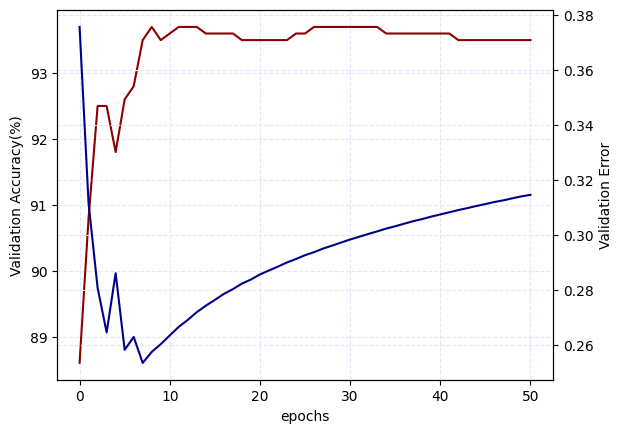

나의 최고 test accuracy :  tensor(93.7000)


In [19]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax_acc = fig.add_subplot(111)

ax_acc.plot(range(epoch_size+1), history['val_acc'], label='정확도(%)', color='darkred')
#plt.text(3, 14.7, "<----------------정확도(%)", verticalalignment='top', horizontalalignment='right')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()

ax_loss.plot(range(epoch_size+1), history['val_loss'], label='오차', color='darkblue')
#plt.text(3, 2.2, "<----------------오차", verticalalignment='top', horizontalalignment='left')
plt.ylabel('Validation Error')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

print("나의 최고 test accuracy : ",max(history['val_acc']))